In [4]:
import pandas as pd
import xlrd 
import xlwt
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
import openpyxl
import os
import glob
import pydicom
import sys
import sklearn.feature_extraction as skl_feat_extrac
import imageio
from scipy.misc import imsave, imread
from skimage import io
import warnings

warnings.filterwarnings("ignore")
print(sys.executable)
pd.options.display.precision=5

e:\python files\envs\thesispy3\scripts\python.exe


# Reading All Excel Files and Combining Them in One File

In [2]:
# set the path to excel files where annotations are avaialable
path = 'F:\Surrey\METADATA'
files_names = glob.glob(path +'\**\*IMAGE.xls')

#initialization
batches_arr = []
attributes_arr = []
print('number of files found', np.shape(files_names))
print('reading all metadata files')

for idx, name in enumerate(files_names):
    
    # read all sheets from all files with IMAGE.xls endings
    batch = pd.read_excel(name)
    lesions_sheet = pd.read_excel(name, sheet_name=1)

    batches_arr.append(batch)
    attributes_arr.append(lesions_sheet)
    print('{} read successfully {}'.format(name, idx))

#make one data frame
all_batches = pd.concat(batches_arr)
all_lesion_sheets = pd.concat(attributes_arr) 

print('sheet 0 shape', all_batches.shape)
print('sheet 1 shape', all_lesion_sheets.shape)


number of files found (25,)
reading all metadata files
F:\Surrey\METADATA\1\batch_1_IMAGE.xls read successfully 0
F:\Surrey\METADATA\10\batch_10_IMAGE.xls read successfully 1
F:\Surrey\METADATA\11\batch_11_IMAGE.xls read successfully 2
F:\Surrey\METADATA\12\batch_12_IMAGE.xls read successfully 3
F:\Surrey\METADATA\13\batch_13_IMAGE.xls read successfully 4
F:\Surrey\METADATA\14\batch_14_IMAGE.xls read successfully 5
F:\Surrey\METADATA\15\batch_15_IMAGE.xls read successfully 6
F:\Surrey\METADATA\16\batch_16_IMAGE.xls read successfully 7
F:\Surrey\METADATA\17\batch_17_IMAGE.xls read successfully 8
F:\Surrey\METADATA\18\batch_18_IMAGE.xls read successfully 9
F:\Surrey\METADATA\19\batch_19_IMAGE.xls read successfully 10
F:\Surrey\METADATA\2\batch_2_IMAGE.xls read successfully 11
F:\Surrey\METADATA\20\batch_20_IMAGE.xls read successfully 12
F:\Surrey\METADATA\21\batch_21_IMAGE.xls read successfully 13
F:\Surrey\METADATA\22\batch_22_IMAGE.xls read successfully 14
F:\Surrey\METADATA\23\batch_2

In [9]:
## for report images
path = 'E:\\Python files\\Pandas\\all_batches.xlsx'
path2 = 'E:\\Python files\\Pandas\\all_lesions.xlsx'
all_batches = pd.read_excel(path)
all_lesion_sheets = pd.read_excel(path2)

# Reading and Filtering Images

In [17]:
cond1 = all_batches['PresentationIntentType']=='FOR PRESENTATION'
cond2 = all_batches['ManufacturersModelName']=='Lorad Selenia'

cond3 = all_batches['BatchID']==1
cond4 = all_batches['Manufacturer']== 'HOLOGIC, Inc.' #''

cond5 = all_batches['EstimatedRadiographicMagnificationFactor']==1.0
cond6 = all_batches['XRayTubeCurrent']==100.0

filtered_batches = all_batches[cond1 & cond2 & cond4 & cond5 & cond6]

# add a column to indicate whether this image has a lesion or not
filtered_batches['HasLesion'] = filtered_batches['ImageSOPIUID'].isin(all_lesion_sheets['ImageSOPIUID'])

print('filtered batches with lesions shape', filtered_batches[filtered_batches['HasLesion']].shape)

filtered_batches.head(5)
# to print the number of patients
print(len(np.unique(filtered_batches['ClientID'])), 'patients in filtered batches')

# wow a good description
all_batches.describe()
all_batches.values
all_batches.info
all_batches.tail(10)

print('filtered batches shape', filtered_batches.shape)


filtered batches with lesions shape (271, 24)
141 patients in filtered batches
filtered batches shape (570, 24)


# Reading Randomly the Filtered Images, Creating Masks and Saving Them

D:\Eextension\1\1215\1.2.752.24.7.1094649314.362379\1.2.840.113681.2229466362.937.3526272495.118.1.dcm 0
D:\Eextension\1\130\1.2.752.24.7.1094649314.226531\1.2.840.113681.2229466362.959.3498797771.461.1.dcm 1
D:\Eextension\1\1357\1.2.752.24.7.1094649314.214634\1.2.840.113681.2230565232.949.3496462259.607.1.dcm 2
D:\Eextension\1\1253\1.2.752.24.7.1094649314.352882\1.2.840.113681.2229466322.922.3526534305.514.1.dcm 3
D:\Eextension\1\1333\1.2.752.24.7.1094649314.298423\1.2.840.113681.2229466362.966.3515402569.250.1.dcm 4
D:\Eextension\1\1433\1.2.752.24.7.1094649314.220719\1.2.840.113681.2229466362.975.3497507161.501.1.dcm 5
D:\Eextension\1\1085\1.2.752.24.7.1094649314.289389\1.2.840.113681.2229466322.924.3510308242.369.1.dcm 6
D:\Eextension\1\1112\1.2.752.24.7.1094649314.317191\1.2.840.113681.2230565232.950.3519358215.273.1.dcm 7
D:\Eextension\1\1229\1.2.752.24.7.1094649314.340795\1.2.840.113681.2229461008.933.3524284950.445.1.dcm 8
D:\Eextension\1\1112\1.2.752.24.7.1094649314.317191\1.2.

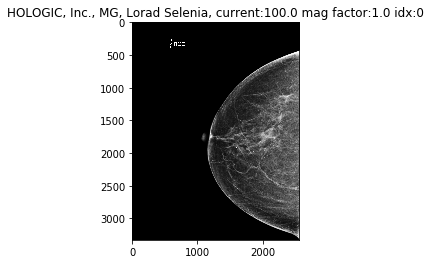

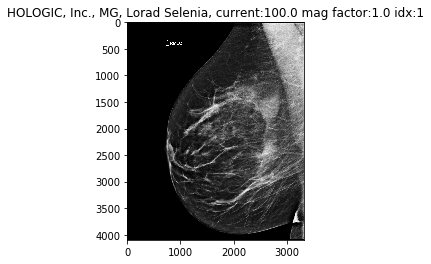

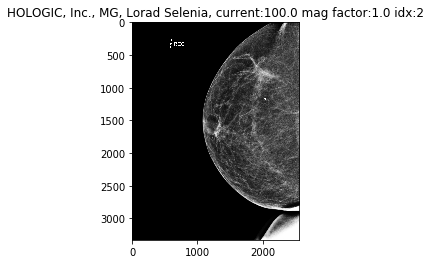

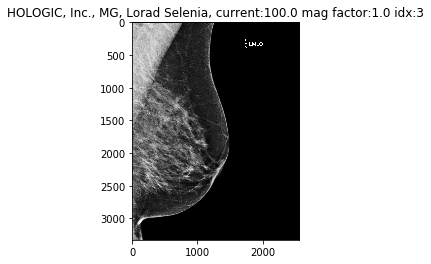

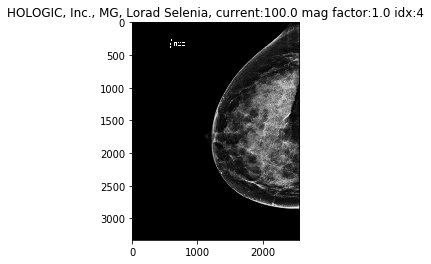

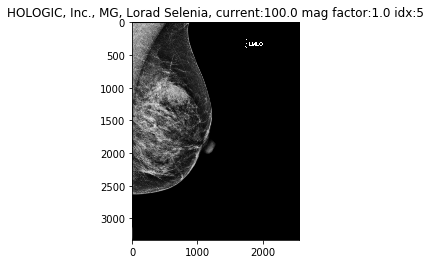

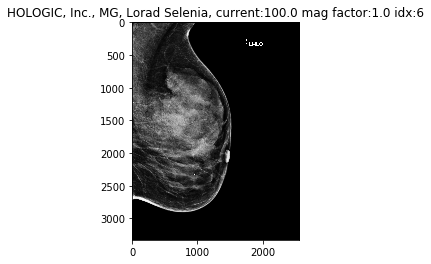

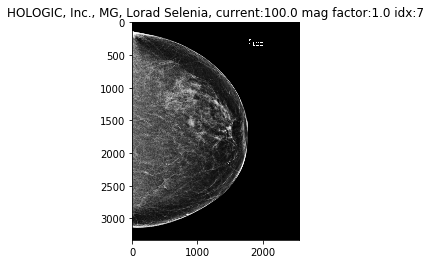

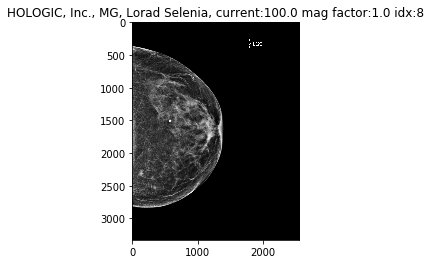

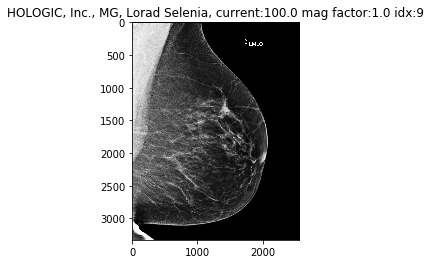

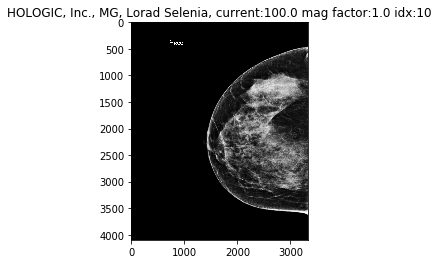

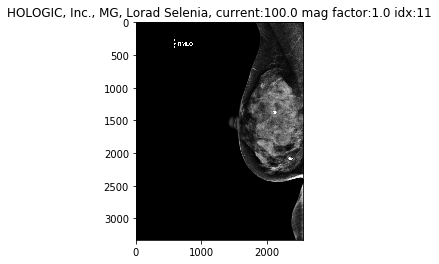

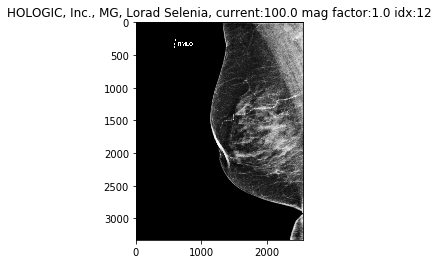

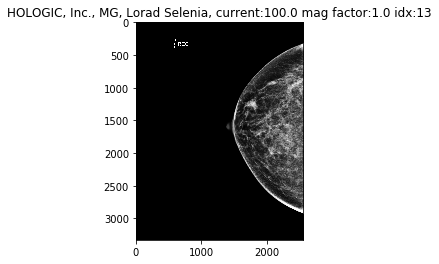

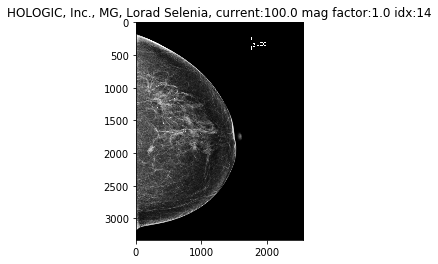

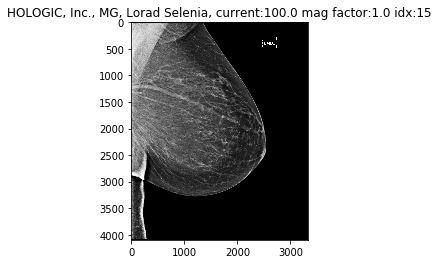

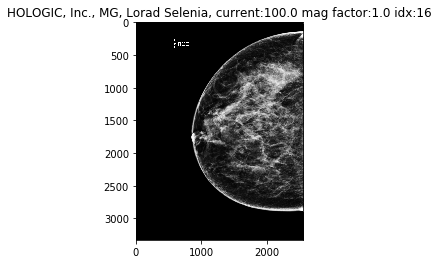

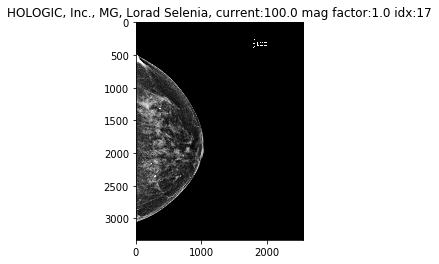

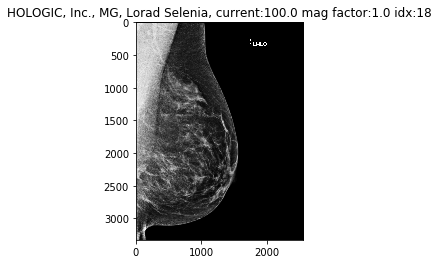

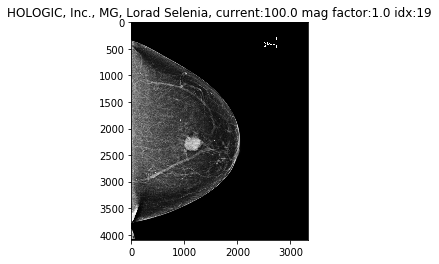

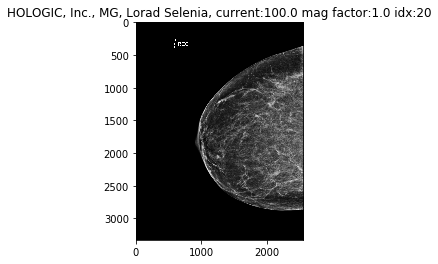

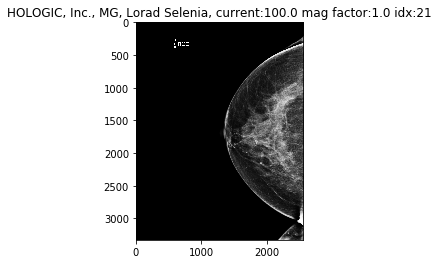

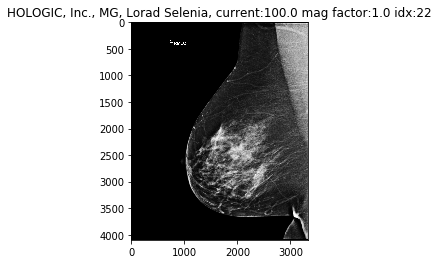

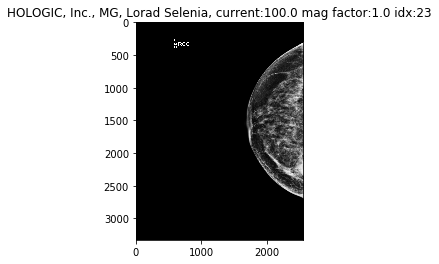

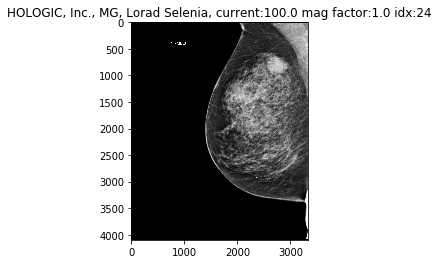

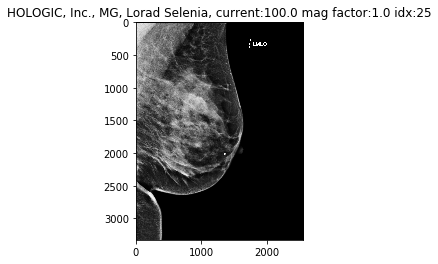

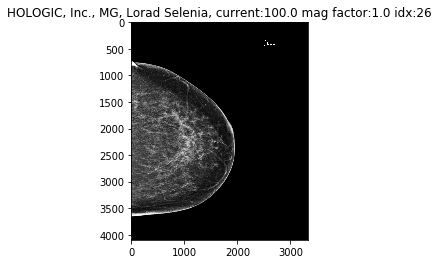

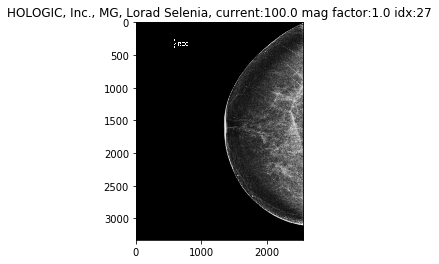

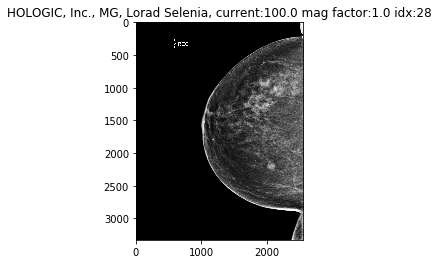

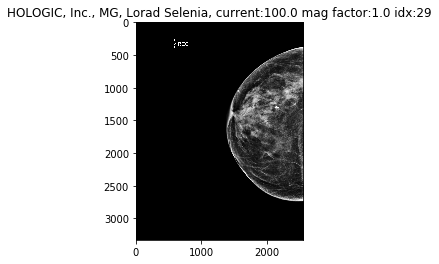

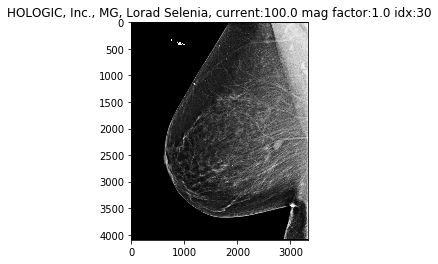

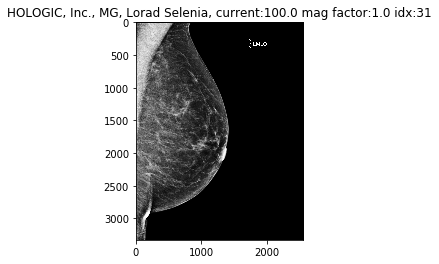

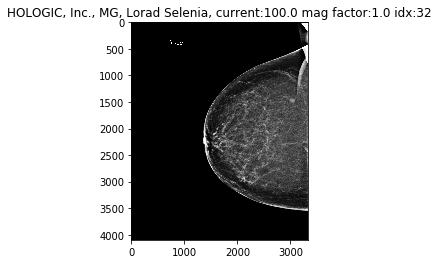

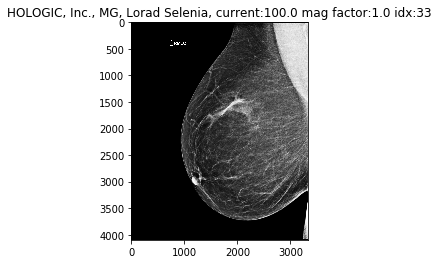

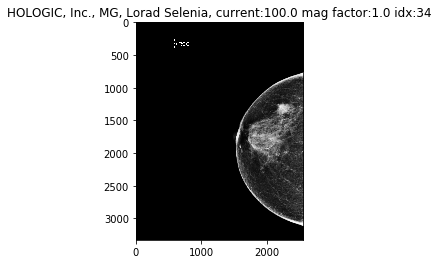

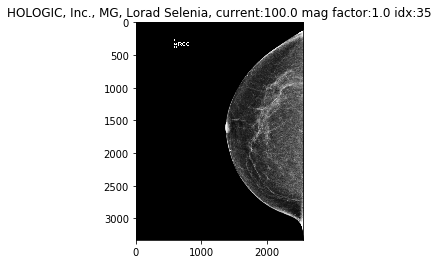

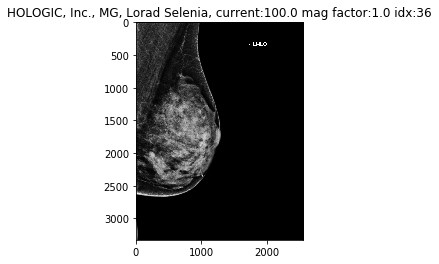

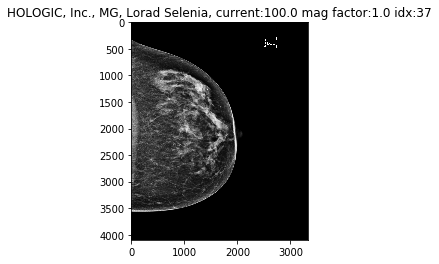

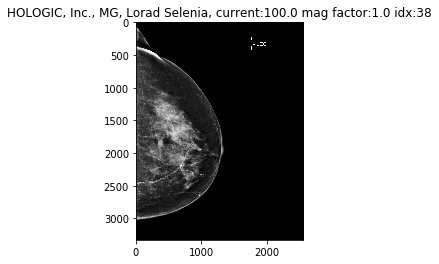

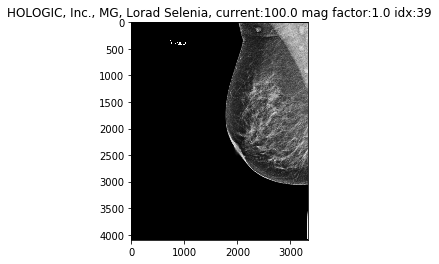

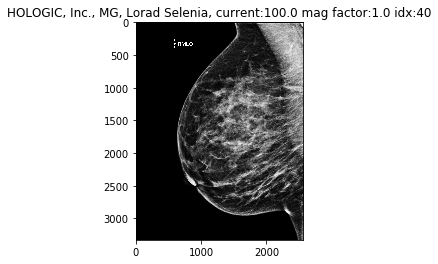

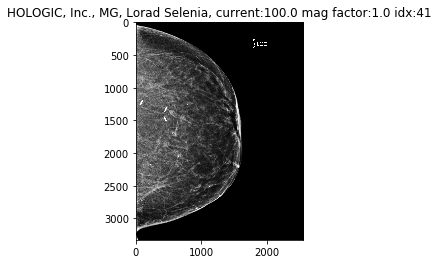

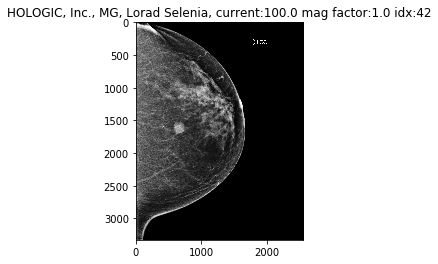

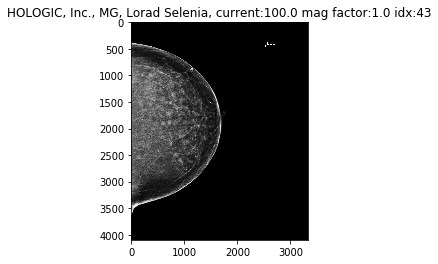

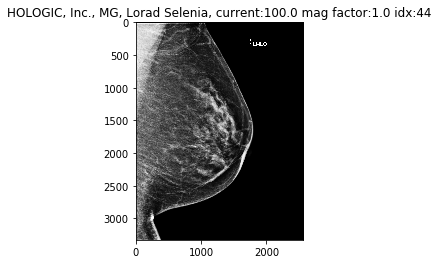

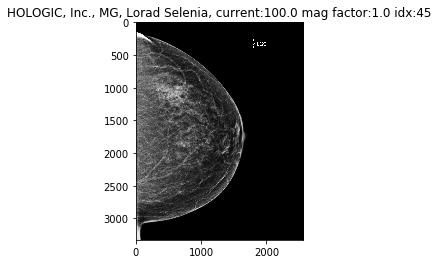

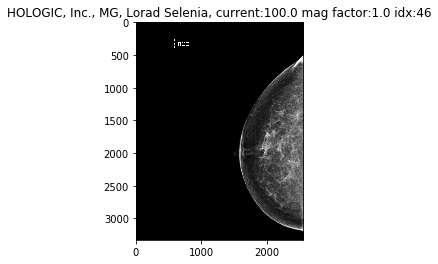

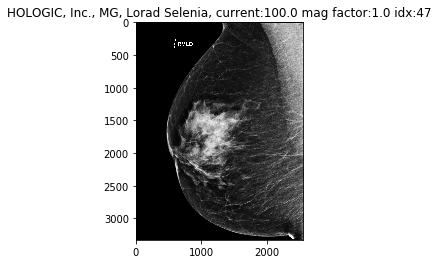

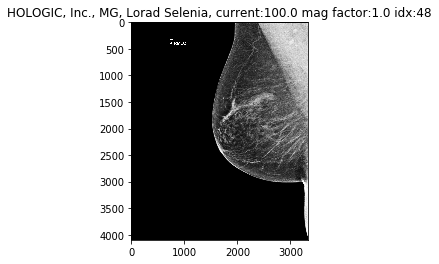

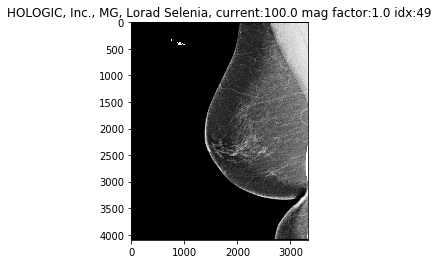

In [18]:
# dcm_path = 'F:\\Surrey\\UnCompressed'
dcm_path  = 'D:\\Eextension' #temp

mask_path = 'E:\\Python files\\UdG\\Thesis\\Datasets\\OPTIMAM\\mask'

#how many missing files in the batch from the source
miss_idx =0
n= 50
frac = None
# pick randomly n cases to consider
batch_sample = filtered_batches.sample(n=n, frac=frac)

for row in range(batch_sample.shape[0]):#
    batch_num = batch_sample.iloc[row]['BatchID']
    patien_id = batch_sample.iloc[row]['ClientID']
    
    study_id = batch_sample.iloc[row]['StudyIUID']
    image_id = batch_sample.iloc[row]['ImageSOPIUID']
    
    modality = batch_sample.iloc[row]['Modality']
    manufac  = batch_sample.iloc[row]['Manufacturer']
    
    model_name = batch_sample.iloc[row]['ManufacturersModelName']
    magnif_factor = batch_sample.iloc[row]['EstimatedRadiographicMagnificationFactor']
    
    current = batch_sample.iloc[row]['XRayTubeCurrent']
    
    file_name = os.path.join(dcm_path, str(batch_num), str(patien_id), str(study_id), str(image_id)) + '.dcm'
    mask_folder = os.path.join(mask_path, str(batch_num), str(patien_id), str(study_id))
    mask_name = os.path.join(mask_folder, str(image_id)) + '_msk.png'
    
    # check whether the folder exists, if not create it
##     if ~os.path.exists(mask_folder):
##        os.makedirs(mask_folder, exist_ok=True)
    
    # read the dicom file, and extract the pixel array only
    if os.path.exists(file_name):
        dcm_file = pydicom.dcmread(file_name)
        
        img = dcm_file.pixel_array
        print(file_name + ' {}'.format(str(row)))

        # create the mask and save it, the first one is more powerful than the second one
        mask =  np.asarray((img>0)*255 , dtype = np.uint8) # = type(img[0,0])
        
        # this way of saving images is quite good, using MISC
##         imsave(mask_name, mask)
##         new_mask = imread(mask_name) 
##         print('after saving img, mask shape', np.shape(img), np.shape(new_mask), type(new_mask[0,0]))

    # saving the mask, WARNING: this method produces 4 channels in the outputs
##         plt.imsave(mask_name, mask, cmap='gray')# 
#         plt.figure()
##        plt.imshow(new_mask, cmap='gray')
        plt.figure()
        plt.imshow(img, cmap='gray')
        plt.title('{}, {}, {}, current:{} mag factor:{} idx:{}'.format(str(manufac), str(modality), str(model_name), str(current), str(magnif_factor), str(row)))


    else:
        miss_idx+=1
        print(file_name, 'does not exist', miss_idx)

# Creating and Saving Groundtruth Files

In [ ]:
print('total number of non-filtered lesions', all_lesion_sheets.shape)

groundtruth_path = 'E:\\Python files\\UdG\\Thesis\\Datasets\\OPTIMAM\\groundTruth'
mask_path = 'E:\\Python files\\UdG\\Thesis\\Datasets\\OPTIMAM\\mask'

# loop over all images
for row in range(all_lesion_sheets.shape[0]): #

    # read properties
    batch_num = all_lesion_sheets.iloc[row]['BatchID']
    patient_id = all_lesion_sheets.iloc[row]['ClientID']
    
    study_id = all_lesion_sheets.iloc[row]['StudyIUID']
    image_id = all_lesion_sheets.iloc[row]['ImageSOPIUID']
    
    mask_name = os.path.join(mask_path, str(batch_num), str(patient_id), str(study_id), str(image_id))+'_msk.png'
    gt_folder = os.path.join(groundtruth_path, str(batch_num), str(patient_id), str(study_id))
    gt_name = os.path.join(gt_folder, str(image_id)) + '_gt.png'
    
    
    # check whether the mask image exists or not
    if os.path.exists(mask_name):
        x1, x2, y1, y2 = all_lesion_sheets.iloc[row]['X1':'Y2']
        
        # check whether the folder exists, if not create it
        if ~os.path.exists(gt_folder):
            os.makedirs(gt_folder, exist_ok=True)
            
        # read the mask and create a zeros-like matrix, put 255 where lesions exist
        groundtruth = np.zeros_like(io.imread(mask_name))
        groundtruth[y1:y2+1, x1:x2+1] = 255
        io.imsave(gt_name , groundtruth)
        print(gt_name, 'saved\n', row)
        
print('-'*5 + 'DONE!!' + '-'*5)


# Extracting Patches From the Filtered Images, and Saving Them

In [ ]:
# fix the paths where patches, masks, groundtruths, dcm files are (or are going to be)
patches_path = 'E:\\Python files\\UdG\\Thesis\\Datasets\\OPTIMAM\\patches'
mask_path = 'E:\\Python files\\UdG\\Thesis\\Datasets\\OPTIMAM\\mask'

groundtruth_path = 'E:\\Python files\\UdG\\Thesis\\Datasets\\OPTIMAM\\groundTruth'
dcm_path = 'F:\\Surrey\\UnCompressed'

# side size of the square patch
patch_side = 128
patches_per_img = 10

## take all images  no lesions + lesions (+ lesion avoidance technique)
batch_sample = filtered_batches
print(batch_sample.shape[0])

# loop over all images
for row in range( batch_sample.shape[0]): #
    
    # read properties
    batch_num = batch_sample.iloc[row]['BatchID']
    patient_id = batch_sample.iloc[row]['ClientID']
    
    study_id = batch_sample.iloc[row]['StudyIUID']
    image_id = batch_sample.iloc[row]['ImageSOPIUID']
    
    modality = batch_sample.iloc[row]['Modality']
    manufac  = batch_sample.iloc[row]['Manufacturer']
    
    model_name = batch_sample.iloc[row]['ManufacturersModelName']
    magnif_factor = batch_sample.iloc[row]['EstimatedRadiographicMagnificationFactor']
    
    current = batch_sample.iloc[row]['XRayTubeCurrent']
    has_lesion = batch_sample.iloc[row]['HasLesion']
    
    # build the file path and name using the read properties
    file_name = os.path.join(dcm_path, str(batch_num), str(patient_id), str(study_id), str(image_id))
    mask_name = os.path.join(mask_path, str(batch_num), str(patient_id), str(study_id), str(image_id))+'_msk.png'
    
    gt_name = os.path.join(groundtruth_path, str(batch_num), str(patient_id), str(study_id), str(image_id))+'_gt.png'
    patches_folder = os.path.join(patches_path, str(batch_num), str(patient_id), str(study_id), str(image_id))
    
    # check whether the folder exists, if not create it
    if ~os.path.exists(patches_folder):
        os.makedirs(patches_folder, exist_ok=True)
    
    # if the file exists: read the dicom file, and extract the pixel array only
    if os.path.exists(file_name + '.dcm'):
        dcm_file = pydicom.dcmread(file_name + '.dcm')
        img = dcm_file.pixel_array
        
        mini = np.min(img)
        img = ((img - mini)/(np.max(img) - mini)) * 255
        img = np.round(img).astype(np.uint8)
        
        # read the mask and groundtruth corresponding to the image in hand
        mask_img = io.imread(mask_name)
        valid_patches = 0
        
        if has_lesion:
            # read the lesion image if it exists
            gt_img = io.imread(gt_name)
        else:
            # othewise, consider the lesion image as an empty
            gt_img = np.zeros_like(mask_img)
                
        # keep extracting random patches until reaching the required number per image ( or five counts)
        # valid patches are these which lie completely inside the mask
        seed= np.random.randint(low=0, high=100)
        count=0
        while (valid_patches < patches_per_img) & (count < 5):
            
            # extract random patches from image, mask, and groundtruth using the same seed
            # note that the location of any patch is the same for image, mask, and groundtruth, i.e. aligned patches
            img_patches = skl_feat_extrac.image.extract_patches_2d(img, (patch_side, patch_side), 100, random_state= seed)
            mask_patches = skl_feat_extrac.image.extract_patches_2d(mask_img, (patch_side, patch_side), 100, random_state=seed)

            gt_patches = skl_feat_extrac.image.extract_patches_2d(gt_img, (patch_side, patch_side), 100, random_state= seed)

            # iterate over aligned patches from one image and the corresponding mask
            for (patch, mask, gt_patch) in zip(img_patches, mask_patches, gt_patches):

                # break when the required number of patches has been acquired
                if(valid_patches == patches_per_img):
                    break

                # consider only if the patch lies completely inside the mask
                if(np.sum(mask) == 255 * (patch_side**2)) & (np.sum(gt_patch)==0 ):

                    # save the patch and increase the number of valid patches
                    patch_path = os.path.join(patches_folder, str(row)+ '_ptch' + str(valid_patches) + '.png')       
                    io.imsave(patch_path, patch, cmap = 'gray')
                    valid_patches += 1 
                    
            count+=1
                
        print(file_name +' done\n', 'id', row, '\nsaved patches', str(valid_patches), ' has lesion ', has_lesion)
                    
print('-'*8 + 'DONE!!' + '-'*8)

# Normalizing Lesion Images (minmax Normalization) 
# Saving Them With Meaningful Names

In [ ]:
# read all lesions parameters
dcm_path = 'F:\\Surrey\\UnCompressed'
dst_les_path = 'E:\\Python files\\UdG\\Thesis\\Datasets\\OPTIMAM\\input\\Les' 

n=None
frac=1
filtered_lesions = all_lesion_sheets[all_lesion_sheets['ImageSOPIUID'].isin(filtered_batches['ImageSOPIUID'])]

batch_sample = filtered_lesions.sample(n=n, frac=1)
print(batch_sample.shape, 'frame size')

for row in range(batch_sample.shape[0]):
    # read properties
        
    batch_num, patient_id, study_id, image_id = batch_sample.iloc[row]['BatchID':'ImageSOPIUID']
     
    lesion_id = batch_sample.iloc[row]['LesionID']
    status = batch_sample.iloc[row]['Status']
    
    x1, x2, y1, y2 = batch_sample.iloc[row]['X1':'Y2'] 
    height, width = batch_sample.iloc[row][['Height', 'Width']]
    
    # if the lesion is too large, just skip
    if (height > 750) | (width > 750):
        continue
        
    arch_dist, foc_asym = batch_sample.iloc[row][['ArchitecturalDistortion', 'FocalAsymmetry']] == 1
    mass, calcif, with_calcif = batch_sample.iloc[row][['Mass', 'SuspiciousCalcifications','WithCalcification']] ==1
    
#     manufacturer = filtered_batches[filtered_batches['ImageSOPIUID'].astype(str) == str(image_id)]['Manufacturer'][0:2]
    
    # build the file path and name using the read properties
    file_name = os.path.join(dcm_path, str(batch_num), str(patient_id), str(study_id), str(image_id))
    
    # determine the type of the lesion
    types = np.array(['Ad', 'Fa', 'M', 'Cal', 'Wc'])
    indices = [arch_dist, foc_asym, mass, calcif, with_calcif]
    
    # put the lesion type(s) and diagnosis category in the file name
    lesion_type = ''.join(types[indices])
    
    lesion_name = '_'.join(list(map(str, [batch_num, patient_id, image_id, lesion_id, lesion_type, status])))+'.png'
    print(lesion_name, 'height {}, width {}'.format(height, width))
    
    # if the file exists: read the dicom file, and extract the pixel array only
    if os.path.exists(file_name + '.dcm'):
        dcm_file = pydicom.dcmread(file_name + '.dcm')
        
        #extract the pixel array
        img = dcm_file.pixel_array
        
        #normalize intensities
        mini = np.min(img)
        img = ((img - mini)/(np.max(img) - mini)) * 255
        img = np.round(img).astype(np.uint8)
        
        # extract the lesion using the top-left and bottom-right coordinates
        lesion = img[y1: y2+1, x1: x2+1]
        
        #save the lesion
        io.imsave(os.path.join(dst_les_path, lesion_name), lesion)
        print(str(row), 'saved')
        
print('-'*8 + 'DONE!!' + '-'*8)       
# batch_sample2.info()


In [ ]:
# [x for x in [1,2,3, None] if x is not None]
[x for x is not None in [1,2,3]]
#-----------------------------------------------------------------------------------------------------------------------
#                 patch = np.asarray(patch, dtype=np.uint8)
#                     new_patch = io.imread(path)  
#                     plt.figure()
#                     print('shapes of new patch, masks list, patches list', np.shape(new_patch), np.shape(mask_patches), np.shape(img_patches))
#                     plt.imshow(patch, cmap='gray')
#                     plt.imshow(mask, cmap='gray', vmin=0)
                    

#                     print(' a value from the mask, patch, new patch', mask[0,0], type(mask[0,0]), patch[0,0], type(patch[0,0]), new_patch[0,0], type(new_patch[0,0]))                 


#------------------------------------------------------------------------------------------------------        
#         if len(np.shape(mask))>2 : 
#             mask = mask[:,:,0]
#         print('before saving img, mask shape', np.shape(img), np.shape(mask), type(mask[0,0]))